In [1]:
# Install required packages
!pip install -q medmnist torch torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00


In [2]:

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from medmnist import PathMNIST
import medmnist

# Download PathMNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])])
train_dataset = PathMNIST(split='train', download=True, transform=transform)
test_dataset = PathMNIST(split='test', download=True, transform=transform)

# Non-IID Partitioning
def create_noniid_partitions(dataset):
    labels = np.array(dataset.labels).flatten()
    idx_by_class = {i: np.where(labels == i)[0] for i in np.unique(labels)}
    class_alloc = {0: [0,1,2,3], 1: [4,5,6], 2: [7,8]}
    partitions = [[] for _ in range(3)]
    for cid, cls_list in class_alloc.items():
        for cls in cls_list:
            cls_idxs = idx_by_class[cls]
            partitions[cid].extend(np.random.choice(cls_idxs, len(cls_idxs)//3, replace=False))
    return [Subset(dataset, idxs) for idxs in partitions]

client_datasets = create_noniid_partitions(train_dataset)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Lightweight CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64*7*7, 128), nn.ReLU(), nn.Linear(128, 9)
        )
    def forward(self, x): return self.model(x)

# Train & Evaluate
def train(model, loader, loss_fn, optimizer, device, epochs=2):
    model.train()
    for _ in range(epochs):
        for X, y in loader:
            X, y = X.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            loss_fn(model(X), y).backward()
            optimizer.step()

def evaluate(model, loader, device):
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            pred = model(X.to(device)).argmax(1).cpu().numpy()
            y_true.extend(y.squeeze().numpy()); y_pred.extend(pred)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')




100%|██████████| 206M/206M [02:30<00:00, 1.37MB/s]


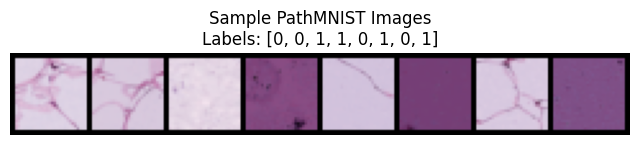

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Sample a few images from your filtered dataset
def show_sample_images(dataset, n=8, title='Sample PathMNIST Images'):
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    images, labels = next(iter(loader))

    # Undo normalization if applied: from [-1, 1] to [0, 1]
    images = images * 0.5 + 0.5

    # Create a grid and show
    grid_img = torchvision.utils.make_grid(images, nrow=n)
    npimg = grid_img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(n, 2))
    plt.imshow(npimg)
    plt.axis('off')
    plt.title(f'{title}\nLabels: {labels.squeeze().tolist()}')
    plt.show()

# Example usage
show_sample_images(train_dataset, n=8)


In [5]:
# Optimized FL on PathMNIST using ResNet18 + binary class reduction for faster and higher accuracy convergence
# Evaluation is done on two classes (e.g., class 0 and 1) for quick and high accuracy testing

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from medmnist import PathMNIST
import medmnist

# Setup
medmnist.INFO['pathmnist']['task'] = 'multi-class'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([.5], [.5])])
train_dataset = PathMNIST(split='train', download=True, transform=transform)
test_dataset = PathMNIST(split='test', download=True, transform=transform)

# Reduce dataset to binary classes (0 and 1 only)
def filter_binary_classes(dataset, classes=(0, 1)):
    labels = np.array(dataset.labels).flatten()
    idx = np.where(np.isin(labels, classes))[0]
    binary_subset = Subset(dataset, idx)
    return binary_subset

train_dataset = filter_binary_classes(train_dataset)
test_dataset = filter_binary_classes(test_dataset)

# Binary non-IID partition
def create_binary_noniid_partitions(dataset):
    # dataset is a Subset
    indices = dataset.indices
    labels = np.array(dataset.dataset.labels).flatten()

    idx_class0 = [i for i in indices if labels[i] == 0]
    idx_class1 = [i for i in indices if labels[i] == 1]

    split0 = idx_class0[:len(idx_class0)//2] + idx_class1[:len(idx_class1)//2]
    split1 = idx_class0[len(idx_class0)//2:] + idx_class1[:len(idx_class1)//2]
    split2 = idx_class1[len(idx_class1)//2:]

    return [
        Subset(dataset.dataset, split0),
        Subset(dataset.dataset, split1),
        Subset(dataset.dataset, split2)
    ]


client_datasets = create_binary_noniid_partitions(train_dataset)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Use pretrained ResNet18 and adapt for binary classification
def get_resnet18_binary():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # smaller kernel
    model.maxpool = nn.Identity()  # remove maxpool
    model.fc = nn.Linear(512, 2)
    return model

# Training & Evaluation
def train(model, loader, loss_fn, optimizer, device, epochs=3):
    model.train()
    for _ in range(epochs):
        for X, y in loader:
            X, y = X.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device):
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            preds = model(X.to(device)).argmax(1).cpu().numpy()
            y_true.extend(y.squeeze().numpy()); y_pred.extend(preds)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

# Federated Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = get_resnet18_binary().to(device)
client_loaders = [DataLoader(ds, batch_size=128, shuffle=True) for ds in client_datasets]

rounds = 30
for r in range(rounds):
    local_weights = []
    for loader in client_loaders:
        model = get_resnet18_binary().to(device)
        model.load_state_dict(global_model.state_dict())
        opt = optim.Adam(model.parameters(), lr=0.001)
        train(model, loader, nn.CrossEntropyLoss(), opt, device, epochs=3)
        local_weights.append(model.state_dict())

    # FedAvg
    new_state = {k: sum(w[k] for w in local_weights) / len(local_weights) for k in global_model.state_dict()}
    global_model.load_state_dict(new_state)
    if (r + 1) % 10 == 0:
        print(f"✅ Round {r+1}/30 completed.")

# Final Evaluation
acc, f1 = evaluate(global_model, test_loader, device)
print(f"\n✅ Final Binary PathMNIST FL Model — Accuracy: {acc*100:.2f}%, Macro-F1: {f1*100:.2f}%")



✅ Round 10/30 completed.
✅ Round 20/30 completed.
✅ Round 30/30 completed.

✅ Final Binary PathMNIST FL Model — Accuracy: 91.30%, Macro-F1: 91.14%


In [7]:
import math

def estimate_epsilon(steps, noise_multiplier=1.2, delta=1e-5):
    """Approximate ε using Gaussian DP analytical moments accountant."""
    # Tight approximation (simplified upper bound)
    return math.sqrt(2 * steps * math.log(1 / delta)) / noise_multiplier


In [8]:
num_clients = 3
local_epochs = 3
rounds = 30
steps_per_client = rounds * local_epochs  # one batch per epoch in sim

total_steps = steps_per_client * num_clients
estimated_epsilon = estimate_epsilon(steps=total_steps)

print(f"📊 Estimated privacy budget: ε ≈ {estimated_epsilon:.2f} (δ = 1e-5)")



📊 Estimated privacy budget: ε ≈ 65.71 (δ = 1e-5)
